In [43]:
# importing libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score 

import joblib
import pickle


import warnings
warnings.filterwarnings('ignore')

## **1. Data Loading and Inspection**

In [44]:
df = pd.read_csv('insurance.csv')

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [45]:
# basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [46]:
# summary stats
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## **2. Data Cleaning**

### **2.1 Check and Handle missing values**

In [47]:
#check NaN types
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [48]:
# check categorical features for missing values
df['sex'].unique()

array(['female', 'male'], dtype=object)

In [49]:
df['smoker'].unique()

array(['yes', 'no'], dtype=object)

In [50]:
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

There are no empty spaces as well as missing values in the dataset!

### **2.2 Check and Handle Outliers**

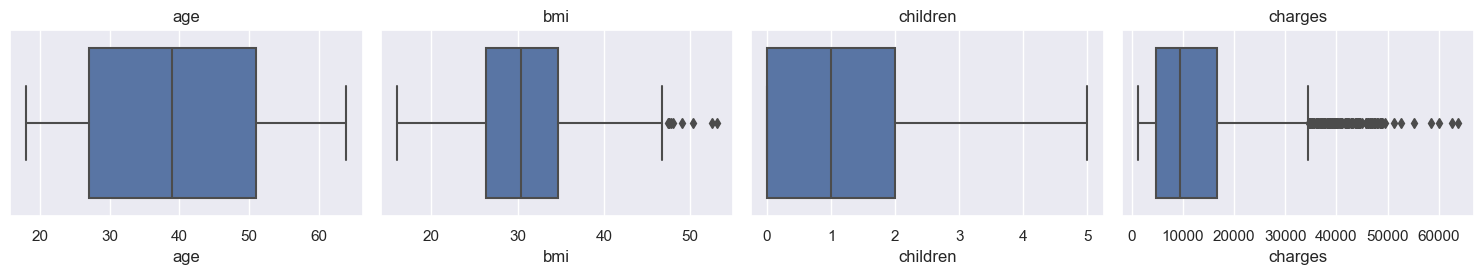

In [51]:
# boxplot of features
# Set the aesthetic style of the plots
sns.set(style="darkgrid")

# Create boxplots for numerical features
numerical_features = df.select_dtypes(include=['float', 'int']).columns.tolist()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(4, 4, i + 1)
    sns.boxplot(x=df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

`remove_outluers` function:  

The function below identifies the number of outliers in each column as well as the percentage of the found outliers.  
With a threshold of 20% the function removes outliers, once they exceed 20%.

In [52]:
# function to check outliers

def remove_outliers(df):
    outlier_percentages = {}
    
    # Iterate over each numeric column
    for column in df.select_dtypes(include='number'):
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        
        # Calculate IQR
        IQR = Q3 - Q1
        
        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        
        # Calculate the percentage of outliers
        outlier_percentage = len(outliers) / len(df) * 100
        outlier_percentages[column] = outlier_percentage
        
        print(f"Column: {column}")
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {outlier_percentage:.2f}%")
        
        # Remove outliers if they exceed 20%
        if outlier_percentage > 20:
            df[column] = df.loc[~((df[column] < lower_bound) | (df[column] > upper_bound)), column]
            print("Outliers removed due to exceeding 20% threshold.")
        else:
            print("No outliers removed.")
        
        print()
    
    return df, outlier_percentages

In [53]:
df, outlier_percentages = remove_outliers(df)

Column: age
Number of outliers: 0
Percentage of outliers: 0.00%
No outliers removed.

Column: bmi
Number of outliers: 9
Percentage of outliers: 0.67%
No outliers removed.

Column: children
Number of outliers: 0
Percentage of outliers: 0.00%
No outliers removed.

Column: charges
Number of outliers: 139
Percentage of outliers: 10.39%
No outliers removed.



### **Check and Handle Duplicates**

In [54]:
dup_num = df.duplicated().sum()
print(f"There are/is {dup_num} duplicate(s) in the data")

There are/is 1 duplicate(s) in the data


In [55]:
# removing duplicates
df_clean = df.drop_duplicates()

## **3. Exploratory Data Analysis**  

In this section, we explore the data, revealing characteristics such as distributions, correlations, etc.

### **3.1 Distributions**

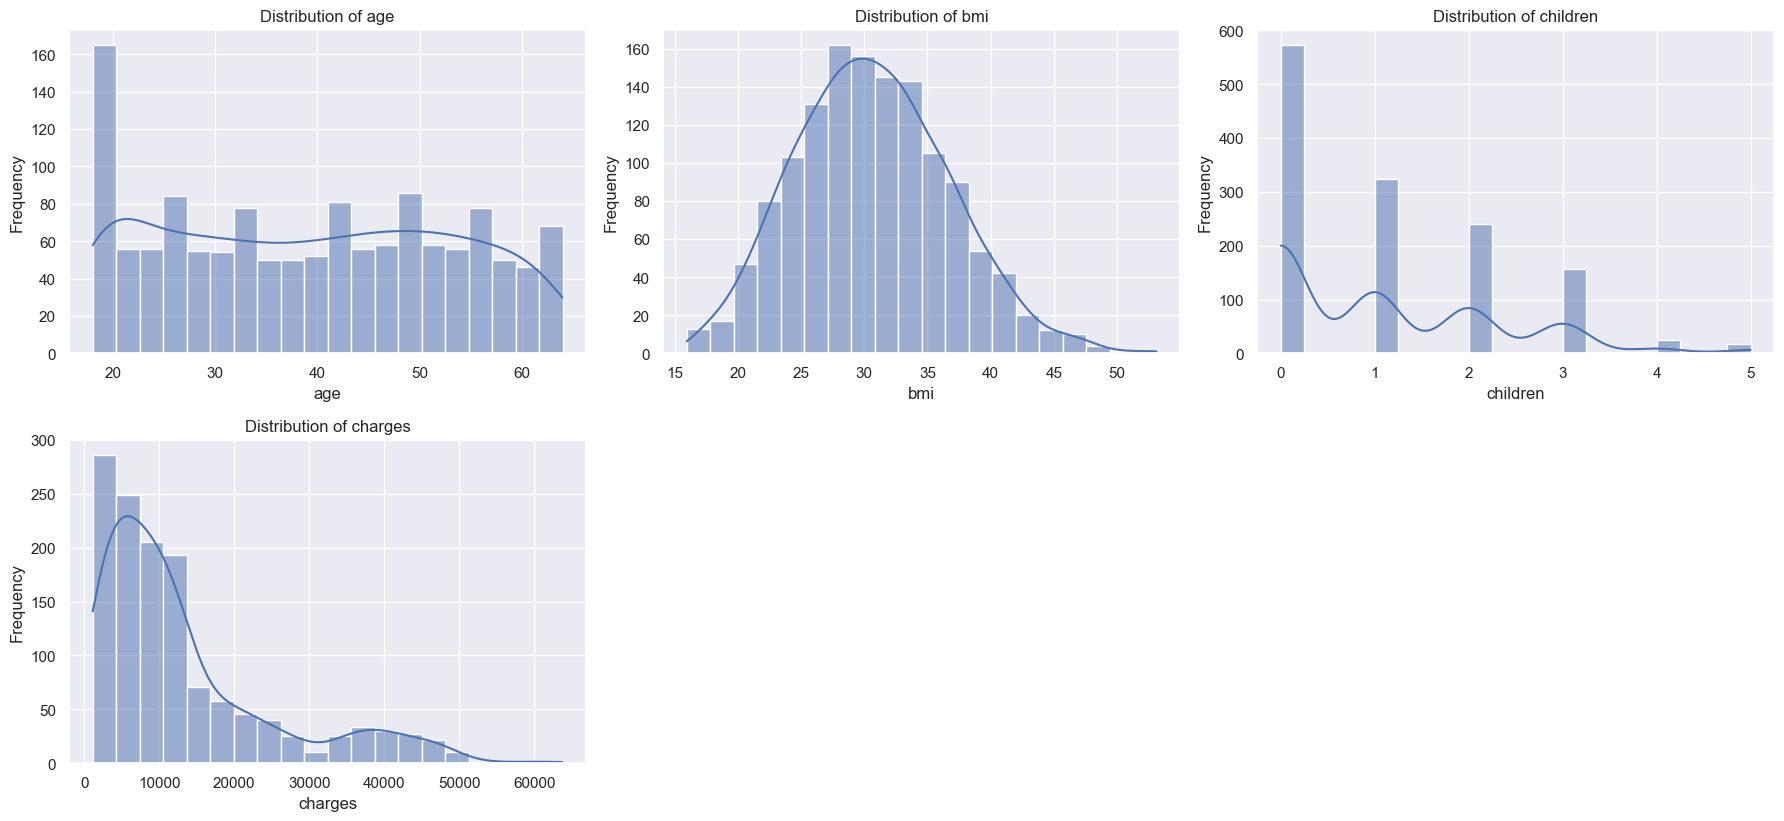

In [56]:
# create figure
plt.figure(figsize=(18,12))

# iterate through columns to plot and create subplots
for i, column in enumerate(numerical_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_clean[column], kde=True, bins=20)
    # set title
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### **3.2 Correlations**

In [57]:
# define the numerical features:
num_feats = df_clean.select_dtypes(include=['int', 'float']).columns.tolist()
correlations = df_clean[num_feats].corr()
correlations

,age,bmi,children,charges
age,1.000000,0.109344,0.041536,0.298308
bmi,0.109344,1.000000,0.012755,0.198401
children,0.041536,0.012755,1.000000,0.067389
charges,0.298308,0.198401,0.067389,1.000000


## **4. Data Preprocessing**

### **4.1 Label Encoding**

In [58]:
# define categorical features
cat_feats = df_clean.select_dtypes(include='object').columns.tolist()

# initialize label Encoder
le = LabelEncoder()

# fit and transform categorical features
for feature in cat_feats:
    df_clean[feature] = le.fit_transform(df_clean[feature])

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### **4.2 Data Splitting**

In [59]:
# Split the data into features and target
X = df_clean.drop('charges', axis=1)
y = df_clean['charges']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## **5. Model Training**  

`Using a Pipeline`

In [60]:
# Create the numerical and categorical transformers
num_transformer = MinMaxScaler()


num_features = X.select_dtypes(include=['float', 'int']).columns.tolist()


preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features)
])

In [61]:
# Create the pipelines
pipelines = {
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'RandomForestRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ]),
    'GradientBoostingRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor())
    ]),
    'XGBRegressor': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor())
    ])
}


In [62]:
# Initialize variables to track the best model
best_model_name = None
best_model_pipeline = None
best_r2_score = -float('inf')  # Start with negative infinity for comparison
best_cv_r2_score = -float('inf')  # Start with negative infinity for comparison

# Train and evaluate the pipelines
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse = mse**0.5
    
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    cv_r2_score = scores.mean()
    
    print(f"{name}:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse: .2f}")
    print(f"R2 Score: {r2:.2f}")
    print(f"Cross-validation R2 Score: {cv_r2_score:.2f} (+/- {scores.std():.2f})\n")


    # check r2 and cvr2 scores for best model
    if (r2 > best_cv_r2_score) and (cv_r2_score > best_cv_r2_score):
        best_r2_score = r2
        best_cv_r2_score = cv_r2_score
        best_model_name = name
        best_model_pipeline = pipeline


# Save the best model
if best_model_pipeline is not None:
    joblib.dump(best_model_pipeline, f'best_model_{best_model_name}.pkl')
    print(f"Best model '{best_model_name}' saved as 'best_model_{best_model_name}.pkl'")

LinearRegression:
Mean Squared Error: 35493102.61
Root Mean Squared Error:  5957.61
R2 Score: 0.81
Cross-validation R2 Score: 0.75 (+/- 0.02)

RandomForestRegressor:
Mean Squared Error: 22023600.52
Root Mean Squared Error:  4692.93
R2 Score: 0.88
Cross-validation R2 Score: 0.84 (+/- 0.03)

GradientBoostingRegressor:
Mean Squared Error: 18620316.53
Root Mean Squared Error:  4315.13
R2 Score: 0.90
Cross-validation R2 Score: 0.86 (+/- 0.03)

XGBRegressor:
Mean Squared Error: 24331646.21
Root Mean Squared Error:  4932.71
R2 Score: 0.87
Cross-validation R2 Score: 0.81 (+/- 0.03)

Best model 'GradientBoostingRegressor' saved as 'best_model_GradientBoostingRegressor.pkl'
